https://nbviewer.jupyter.org/gist/antimon2/dd23b1e62d5fcd08d91fd420d7ba996d/Mandelbrot.mt.cu.jl.ipynb

typeof(c) = Matrix{ComplexF64}
  0.166586 seconds (315.07 k allocations: 17.280 MiB, 4.88% gc time, 36.51% compilation time)
  0.106488 seconds (4 allocations: 512.078 KiB)
typeof(m) = Matrix{Int64}


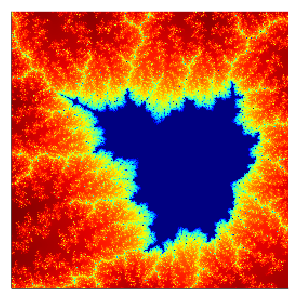

In [1]:
using BenchmarkTools
using Plots
gr(fmt=:png)

plotmandelbrot(m) = heatmap(m; c=reverse(cgrad(:jet1)), 
    size=(300, 300), colorbar=false, ticks=false, frame=false)

function mandelbrot(c; maxiters=2^10, threshold_abs2=Inf)
    z = zero(c)
    for i in 1:maxiters
        z = z * z + c
        abs2(z) ≥ threshold_abs2 && return i
    end
    maxiters + 1
end

n = 2^8
x = range(-0.714689, -0.714679; length=n)
y = range( 0.299872,  0.299882; length=n)
c = complex.(x', y)

@show typeof(c)
@time m = mandelbrot.(c)
@time m = mandelbrot.(c)
@show typeof(m)
plotmandelbrot(m)

typeof(c32) = Matrix{ComplexF32}
  0.156240 seconds (302.85 k allocations: 16.609 MiB, 32.38% compilation time)
  0.107210 seconds (4 allocations: 512.078 KiB)
typeof(m32) = Matrix{Int64}


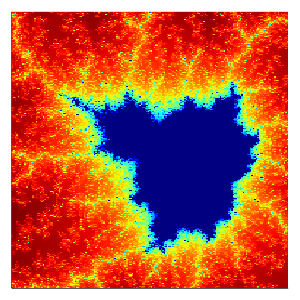

In [2]:
x32 = range(-0.714689f0, -0.714679f0; length=n)
y32 = range( 0.299872f0,  0.299882f0; length=n)
c32 = complex.(x32', y32)

@show typeof(c32)
@time m32 = mandelbrot.(c32)
@time m32 = mandelbrot.(c32)
@show typeof(m32)
plotmandelbrot(m32)

typeof(c_cuda) = CuArray{ComplexF32, 2}
 10.305397 seconds (27.44 M allocations: 1.448 GiB, 4.79% gc time, 0.09% compilation time)
  0.000930 seconds (723 allocations: 523.812 KiB)
typeof(mandelbrot.(c_cuda)) = CuArray{Int64, 2}
typeof(collect(mandelbrot.(c_cuda))) = Matrix{Int64}


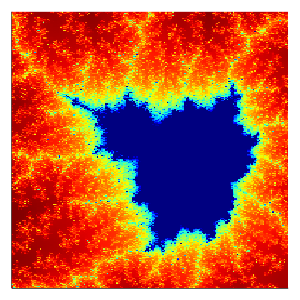

In [3]:
using CUDA
c_cuda = cu(c32)

@show typeof(c_cuda)
@time m_cuda = collect(mandelbrot.(c_cuda))
@time m_cuda = collect(mandelbrot.(c_cuda))
@show typeof(mandelbrot.(c_cuda))
@show typeof(collect(mandelbrot.(c_cuda)))
plotmandelbrot(m_cuda)

Threads.nthreads() = 12
  0.083902 seconds (228.96 k allocations: 12.927 MiB, 82.64% compilation time)
  0.014011 seconds (70 allocations: 519.547 KiB)


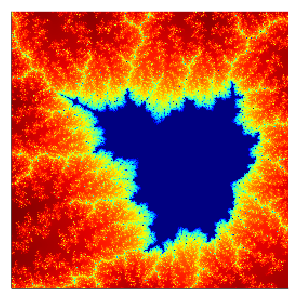

In [4]:
function mandelbrot_threads(c)
    m = similar(c, typeof(mandelbrot(c[end])))
    Threads.@threads for i in keys(c)
        m[i] = mandelbrot(c[i])
    end
    m
end

@show Threads.nthreads()
@time m_th = mandelbrot_threads(c)
@time m_th = mandelbrot_threads(c)
plotmandelbrot(m_th)

In [5]:
@benchmark mandelbrot.($c) # CPU Float64

BenchmarkTools.Trial: 46 samples with 1 evaluation.
 Range (min … max):  105.348 ms … 116.783 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     108.192 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   108.954 ms ±   2.571 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▁    ▁▁  █▄ ▄ ▁█       ▁     ▁                                 
  █▁▁▁▆██▆▆██▆█▁██▁▆▁▆▆▆▁█▆▆▁▆▆█▁▆▁▁▆▁▆▆▁▁▆▁▁▁▁▆▁▁▁▁▁▁▁▁▁▆▁▁▁▁▆ ▁
  105 ms           Histogram: frequency by time          117 ms <

 Memory estimate: 512.05 KiB, allocs estimate: 2.

In [6]:
@benchmark mandelbrot.($c32) # CPU Float32

BenchmarkTools.Trial: 48 samples with 1 evaluation.
 Range (min … max):  104.814 ms … 109.751 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     106.030 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   106.212 ms ± 991.003 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▁ ▁▁ ▁▁  ▄█▁▁▄ ▁ ▁▁▁  ▄ ▄                                    
  ▆▆█▁██▆██▁▁█████▆█▁███▁▁█▁█▆▁▁▁▁▁▆▁▁▆▁▆▁▁▁▁▁▁▁▁▁▁▁▁▆▁▁▁▁▁▁▁▁▆ ▁
  105 ms           Histogram: frequency by time          110 ms <

 Memory estimate: 512.05 KiB, allocs estimate: 2.

In [7]:
@benchmark collect(mandelbrot.($c_cuda)) # GPU Float32 (GPU → GPU)

BenchmarkTools.Trial: 8973 samples with 1 evaluation.
 Range (min … max):  441.200 μs …   6.339 ms  ┊ GC (min … max): 0.00% … 82.32%
 Time  (median):     534.600 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   553.526 μs ± 309.260 μs  ┊ GC (mean ± σ):  4.80% ±  7.59%

    ▄▂          ▃█▅                                              
  ▁▃██▅▃▂▂▂▁▁▁▁▃████▅▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▂
  441 μs           Histogram: frequency by time          811 μs <

 Memory estimate: 514.56 KiB, allocs estimate: 135.

In [8]:
@benchmark collect(mandelbrot.(cu($c))) # GPU Float32 (CPU → GPU → GPU → CPU)

BenchmarkTools.Trial: 6471 samples with 1 evaluation.
 Range (min … max):  607.500 μs …   5.606 ms  ┊ GC (min … max): 0.00% … 76.95%
 Time  (median):     676.800 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   768.311 μs ± 348.081 μs  ┊ GC (mean ± σ):  5.14% ±  9.22%

  █▁                                                             
  ██▄▃█▆▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂ ▂
  608 μs           Histogram: frequency by time          390 ms <

 Memory estimate: 1.00 MiB, allocs estimate: 101.

In [9]:
@show Threads.nthreads()
@benchmark mandelbrot_threads($c) # CPU Float64 multi-threaded version with nthreads = 12

Threads.nthreads() = 12


BenchmarkTools.Trial: 345 samples with 1 evaluation.
 Range (min … max):  13.700 ms … 23.023 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     14.297 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   14.512 ms ±  1.184 ms  ┊ GC (mean ± σ):  0.12% ± 1.28%

  ▇▅▅▇▅█▇▂                                                     
  █████████▇▆▆▄▆▆▄▄▆▁▄▁▄▄▁▁▁▆▄▁▁▆▆▁▆▁▆▁▁▁▁▄▆▁▄▁▁▁▁▁▁▁▁▁▁▄▁▁▁▄ ▇
  13.7 ms      Histogram: log(frequency) by time      20.8 ms <

 Memory estimate: 519.36 KiB, allocs estimate: 64.